In [21]:
from langchain_core.tools import tool
from langchain_community.utilities import SQLDatabase
from dotenv import load_dotenv
import os

from ibm_watsonx_ai import APIClient
from langchain_ibm import ChatWatsonx

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


from sqlalchemy import create_engine, MetaData, ForeignKey, text, insert, URL
from sqlalchemy import text
import pandas as pd
from langchain_core.prompts import PromptTemplate

In [2]:
load_dotenv()
url = os.getenv("URL")
apikey = os.getenv("APIKEY")
project_id = os.getenv("project_id")

In [3]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 100,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

def create_chat_model(model_id):
    return ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)

model_id = "ibm/granite-3-8b-instruct"
llm = create_chat_model(model_id)
llm.invoke("Hello, world!")

AIMessage(content="Hello! It's a pleasure to meet you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 63, 'total_tokens': 82}, 'model_name': 'ibm/granite-3-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'stop'}, id='chatcmpl-99b4e0b831fc6147e4cc3a070afeaa97', usage_metadata={'input_tokens': 63, 'output_tokens': 19, 'total_tokens': 82})

In [ ]:
sqlite_engine = create_engine("sqlite:///Chinook_Sqlite.sqlite",  echo=False)
sqlite_engine.connect()
metadata_obj = MetaData()

db = SQLDatabase(sqlite_engine)
#pd.read_sql(text('SELECT * FROM Album'), sqlite_engine.connect())

In [37]:
query_prompt_template = PromptTemplate.from_template('''   
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}
''')
query_prompt_template.pretty_print()

   
Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}



In [ ]:
from typing import Annotated



class QueryOutput(TypedDict):
    """ Generated SQL query """
    query: Annotated [str, ..., "syntactically correct and valid sql query"]  # ... means there is no instruction

QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'syntactically correct and valid sql query']}

In [81]:

class State(TypedDict):
    question: str
    query: str
    results: str
    answer: str

def write_query (state:State):
    '''
    Generate Sqlite query to fetch information 
    '''
    prompt = query_prompt_template.invoke({
        "dialect":db.dialect,
        "top_k": 5,
        "table_info" : db.get_table_info(),
        "input" : state ['question']
    })

    #return prompt
    structured_llm = llm.with_structured_output(QueryOutput)
    results = structured_llm.invoke(prompt)

    return {"query": results["query"]}
write_query({"question":"list all albums"})

{'query': 'SELECT Title FROM Album LIMIT 5'}

In [111]:
db.dialect

'sqlite'

In [70]:
llm.with_structured_output(QueryOutput)

RunnableBinding(bound=ChatWatsonx(model_id='ibm/granite-3-8b-instruct', project_id='2adbc31f-5dc4-4e42-b730-1e5e360727fd', url=SecretStr('**********'), apikey=SecretStr('**********'), params={'frequency_penalty': 0, 'max_tokens': 100, 'presence_penalty': 0, 'temperature': 0, 'top_p': 1}, watsonx_model=<ibm_watsonx_ai.foundation_models.inference.model_inference.ModelInference object at 0x000001AF5DD105E0>), kwargs={'tools': [{'type': 'function', 'function': {'name': 'QueryOutput', 'description': 'Generated SQL query ', 'parameters': {'type': 'object', 'properties': {'query': {'description': 'syntactically correct and valid sql query', 'type': 'string'}}, 'required': ['query']}}}], 'tool_choice': {'type': 'function', 'function': {'name': 'QueryOutput'}}}, config={}, config_factories=[])
| JsonOutputKeyToolsParser(first_tool_only=True, key_name='QueryOutput')

In [91]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def execute_query (state:State):
    "execute sql query and reurn the result"

    query = state['query']
    execute_query_tool = QuerySQLDataBaseTool(db=db)

    return {"results": execute_query_tool.invoke({"query":query})}

execute_query ({"query":'SELECT Title FROM Album LIMIT 5'})


{'results': "[('For Those About To Rock We Salute You',), ('Balls to the Wall',), ('Restless and Wild',), ('Let There Be Rock',), ('Big Ones',)]"}

In [98]:
#question = "list all tables in the databse"
question = "show me the higher Total sale valued item"

query = write_query({"question":question})
query

{'query': 'SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5'}

In [99]:
def generate_answer(state:State):
    print(state)
    '''generate answer using retrieved information as the context''' 
    prompt = (
        '''given the following user question, corresponding sql query, \
            and sql results, answer question,. \n\n''' 
            f'question: {state["question"]}\n'
            f'sql query:{state["query"]}\n'
            f"sql results: {state['results']}"
    )
    response = llm.invoke(prompt)
    return {"answer":response.content}

In [100]:
results = execute_query(query)
results

{'results': 'Error: (sqlite3.OperationalError) ambiguous column name: TrackId\n[SQL: SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}

In [101]:
state = {"question":question, **query, **results}
state

{'question': 'show me the higher Total sale valued item',
 'query': 'SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5',
 'results': 'Error: (sqlite3.OperationalError) ambiguous column name: TrackId\n[SQL: SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}

In [102]:
generate_answer(state)

{'question': 'show me the higher Total sale valued item', 'query': 'SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5', 'results': 'Error: (sqlite3.OperationalError) ambiguous column name: TrackId\n[SQL: SELECT TrackId, Name, UnitPrice, SUM(Quantity) as TotalQuantity FROM Track JOIN InvoiceLine ON Track.TrackId = InvoiceLine.TrackId GROUP BY TrackId, Name, UnitPrice ORDER BY TotalQuantity DESC LIMIT 5]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'}


{'answer': "The SQL query provided is attempting to select the TrackId column from both the Track and InvoiceLine tables, which is causing an ambiguity error. To resolve this, you should specify the table name when selecting the TrackId column. Here's the corrected SQL query:\n\n```sql\nSELECT t.TrackId, t.Name, t.UnitPrice, SUM(il.Quantity) as TotalQuantity\nFROM Track t\nJOIN InvoiceLine il ON t.TrackId = il.Track"}

## Graph

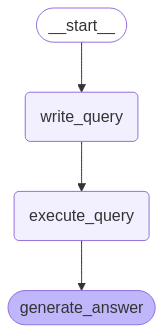

In [105]:
graph_builder = StateGraph(State)
graph_builder.add_node("write_query",write_query)
graph_builder.add_node("execute_query",execute_query)
graph_builder.add_node("generate_answer",generate_answer)
graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query","execute_query")
graph_builder.add_edge("execute_query","generate_answer")

graph = graph_builder.compile()
graph

In [108]:
query = P={'question':"hello"}
for step in graph.stream(query, stream_mode = "updates"):
    print(step)

{'write_query': {'query': 'SELECT * FROM Employee LIMIT 5'}}
{'execute_query': {'results': "[(1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com'), (2, 'Edwards', 'Nancy', 'Sales Manager', 1, '1958-12-08 00:00:00', '2002-05-01 00:00:00', '825 8 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 2T3', '+1 (403) 262-3443', '+1 (403) 262-3322', 'nancy@chinookcorp.com'), (3, 'Peacock', 'Jane', 'Sales Support Agent', 2, '1973-08-29 00:00:00', '2002-04-01 00:00:00', '1111 6 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 5M5', '+1 (403) 262-3443', '+1 (403) 262-6712', 'jane@chinookcorp.com'), (4, 'Park', 'Margaret', 'Sales Support Agent', 2, '1947-09-19 00:00:00', '2003-05-03 00:00:00', '683 10 Street SW', 'Calgary', 'AB', 'Canada', 'T2P 5G3', '+1 (403) 263-4423', '+1 (403) 263-4289', 'margaret@chinookcorp.com'), (5, 'Johnson', 'Steve', 'Sal

# agent

In [109]:
query_prompt_template = PromptTemplate.from_template('''You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

To start you should ALWAYS look at the tables in the database to see what you can query.
Do NOT skip this step.
Then you should query the schema of the most relevant tables.''')

query_prompt_template

PromptTemplate(input_variables=['dialect', 'top_k'], input_types={}, partial_variables={}, template='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.\n\nDO NOT make any DML statements (INSERT, UPDA

In [112]:
system_prompt = query_prompt_template.invoke({'dialect':db.dialect, 'top_k':5})
system_prompt

StringPromptValue(text='You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct sqlite query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.\n\nDO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.\n\nTo start you should ALWAYS look at the tabl

In [113]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db= db, llm = llm)

toolkit.get_context()

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

In [ ]:
toolkit.get_context()['table_info'].pretty_``

'\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEG